In [1]:
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
import requests
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import random
import numpy as np
import pandas as pd
import itertools
from sklearn import svm
from sklearn import tree
from urllib import request
from random import randint
#from wordcloud import WordCloud
from nltk import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import gensim
from gensim.models import LdaModel, Word2Vec
import pyLDAvis
import pyLDAvis.gensim_models
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.stem import WordNetLemmatizer
#!pip install mlxtend
#from mlxtend.evaluate import bias_variance_decomp
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hadyo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
books_url_list = ["https://www.gutenberg.org/files/19719/19719-0.txt",
                  "https://www.gutenberg.org/cache/epub/28434/pg28434.txt",
                  "https://www.gutenberg.org/cache/epub/15147/pg15147.txt",
                  "https://www.gutenberg.org/cache/epub/17866/pg17866.txt",
                  "https://www.gutenberg.org/files/3772/3772-0.txt"]

In [84]:
books_url_list = ["https://www.gutenberg.org/files/84/84-0.txt",
                  "https://www.gutenberg.org/cache/epub/28434/pg28434.txt",
                  "https://www.gutenberg.org/cache/epub/3623/pg3623.txt",
                  "https://www.gutenberg.org/cache/epub/17866/pg17866.txt",
                  "https://www.gutenberg.org/files/3772/3772-0.txt"]

# Preprocessing

In [85]:
#function read raw data
def read_books(url):
    files = []
    for i in url:
        file = requests.get(url = i)
        files.append(file.content.decode('utf-8'))
    return files

#read raw data
raw_dataset = read_books(books_url_list)
len(raw_dataset)

5

In [86]:
#Function cleaned tokens
def cleaned_text(raw_text):
    text_beg = raw_text.find("*** START OF")
    text_end = raw_text.find("*** END OF")

    raw_text = raw_text[text_beg : text_end]
    raw_text = re.findall(r"[a-zA-Z]+", raw_text)
    raw_text = " ".join(raw_text).lower()
    tokens = word_tokenize(raw_text)
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return tokens
#Getting cleaned tokens
tokens = []
for i in range(len(raw_dataset)):
    tokens.append(cleaned_text(raw_dataset[i]))
len(tokens)

5

In [87]:
#function to extract author name, book name and labels
def extract_book_author(raw_text, index):
    label = chr(index + 97)
        
    title_beg = raw_text.find("Title") + 7
    title_end = raw_text.find("\r\n\r\nAuthor")
    title = raw_text[title_beg : title_end]

    author_beg = raw_text.find("Author") + 8
    c = 0
    while raw_text[author_beg + c] != "\r":
        c += 1
        author_end = author_beg + c
    author = raw_text[author_beg : author_end]
    return label, title, author

#getting the author name, book name, labels
label, author, title = [], [], []
for i in range(len(raw_dataset)):
    label_temp, title_temp, author_temp = extract_book_author(raw_dataset[i],i)
    label.append(label_temp)
    author.append(author_temp)
    title.append(title_temp)
    
print(len(label))
print(len(author))
print(len(title))
print(len(tokens))

5
5
5
5


In [104]:
#function to partition data
def partitioned_text(tokens, title, author, label):
    book_partitions = []
    for j in range(len(tokens)):
        for i in range(0, 200):
            partition = [" ".join(tokens[j][i : i + 150]), title[j], author[j], label[j]]
            book_partitions.append(partition)
            #if(subtractor > 150):
             #   partition = [" ".join(tokens[j][i : i + 150]), title[j], author[j], label[j]]
              #  book_partitions.append(partition)
               # subtractor -= 150
    #random.shuffle(book_partitions)
    return book_partitions

In [109]:
#function to partition data
def partitioned_text(tokens, title, author, label):
    book_partitions = []
    for i in range(0, len(tokens) -150, 150):
        partition = [" ".join(tokens[i : i + 150]), title, author, label]
        book_partitions.append(partition)
    return book_partitions

In [120]:
partitions = []
for i in range(len(books_url_list)):
    book_partitions = partitioned_text(tokens[i], title[i], author[i], label[i])
    random.shuffle(book_partitions)
    book_partitions = book_partitions[0:200]
    partitions += book_partitions
    
partitions = np.array(partitions)
dataset = {"partitions": partitions[:, 0],
            "title": partitions[:, 1],
            "author": partitions[:, 2],
            "label": partitions[:, 3]
            }
dataset = pd.DataFrame(dataset)
dataset = dataset.sample(frac=1).reset_index(drop=True)
    

In [121]:
#getting partitoins

#partitions = pd.DataFrame(partitioned_text(tokens, title, author, label), columns = ['partitions', 'title', 'author', 'label'])
#partitions = partitions.sample(frac=1).reset_index(drop=True)
dataset

,partitions,title,author,label
0,clerval woman another elizabeth even affection...,"Frankenstein\r\n or, The Modern Prometheus",Mary Wollstonecraft (Godwin) Shelley,a
1,day asked fire gun near village frighten away ...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c
2,pomp wearing crown blue mantle carrying sceptr...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c
3,vi p like manner inferior portion earth crust ...,The Student’s Elements of Geology,Sir Charles Lyell,e
4,led sheep sacred ground separated lamb dam pla...,The Golden Bough\r\n A study of magic an...,Sir James George Frazer,c
...,...,...,...,...
995,nay became capable bestowing animation upon li...,"Frankenstein\r\n or, The Modern Prometheus",Mary Wollstonecraft (Godwin) Shelley,a
996,clay slate chlorite schist hypogene metamorphi...,The Student’s Elements of Geology,Sir Charles Lyell,e
997,rand favored display pained surprise replied b...,Murder in the Gunroom,Henry Beam Piper,d
998,vancouver island conchologist regard variety t...,The Student’s Elements of Geology,Sir Charles Lyell,e


# Feature Engineering

## BOW model

In [122]:
def model_BOW(data): # take the partitions
    cv = CountVectorizer()
    cv_fit = cv.fit_transform(data)
    cv_fit_df = pd.DataFrame(cv_fit.toarray(), columns = cv.get_feature_names())
    return cv_fit_df
    
bow_vectorizer = model_BOW(dataset['partitions'])
bow_vectorizer

,aah,aargau,aaron,aarvo,abandon,abandoned,abated,abatement,abb,abbeville,...,zodiacal,zone,zonites,zoolas,zoological,zoophyte,zorger,zu,zulu,zululand
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF model

In [123]:
def model_TFIDF(data): # take the partitions
    tfIdf = TfidfVectorizer(use_idf=True)
    tfidf_fit = tfIdf.fit_transform(data).toarray()
    tfidf_fit_df = pd.DataFrame(tfidf_fit, columns = tfIdf.get_feature_names())
    return tfidf_fit_df

tfidf_vectorizer = model_TFIDF(dataset['partitions'])
tfidf_vectorizer

,aah,aargau,aaron,aarvo,abandon,abandoned,abated,abatement,abb,abbeville,...,zodiacal,zone,zonites,zoolas,zoological,zoophyte,zorger,zu,zulu,zululand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LDA as a feature extractor

In [125]:
def model_LDA2(data): # take the partitions
    cv = CountVectorizer(max_df = 0.9, min_df = 2)
    dtm = cv.fit_transform(data)
    lda = LatentDirichletAllocation(n_components = 5, random_state = 5)
    lda = lda.fit_transform(dtm)
    return lda

lda = model_LDA2(dataset['partitions'])
lda

array([[0.00138469, 0.99444346, 0.00137904, 0.00139464, 0.00139818],
       [0.06640706, 0.11217464, 0.00148389, 0.8184313 , 0.00150312],
       [0.00141747, 0.0014224 , 0.00143868, 0.99429796, 0.00142348],
       ...,
       [0.00139488, 0.00141814, 0.00139212, 0.00139664, 0.99439821],
       [0.93140627, 0.00143551, 0.06428697, 0.00144006, 0.00143118],
       [0.00136215, 0.98215013, 0.0013654 , 0.00137359, 0.01374873]])

## wordembedding model

In [126]:
partitions_splitted = []
for partition in dataset['partitions']:
    temp = partition.split()
    partitions_splitted.append(temp)


In [127]:
def model_word2vec(tokens_data): # take the partitions_splitted
    model = Word2Vec(sentences = tokens_data, vector_size = 150, workers = 6)
    return model

In [128]:
word2vec_model = model_word2vec(partitions_splitted)
word2vec_model

In [129]:
#Create the word document vectors
def doc_vectors(data_tokens, word2vec_model):
    features = []
    for tokens in data_tokens:
        zero_vector = np.zeros(word2vec_model.vector_size)
        vectors = []
        for token in tokens:
            if token in word2vec_model.wv:
                vectors.append(word2vec_model.wv[token])
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis = 0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorized_doc = doc_vectors(partitions_splitted, word2vec_model)


In [130]:
len(vectorized_doc), len(vectorized_doc[0])

(1000, 150)

## KMeans + BOW

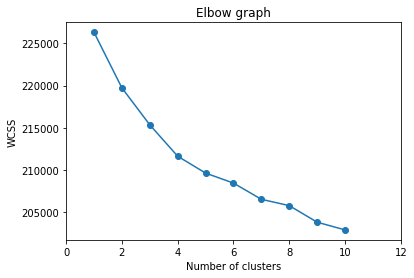

In [131]:
#getting the optimal number of clusters using elbow method
wcs = []
for clusters in range(1, 11):
    kmeans = KMeans(n_clusters = clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(bow_vectorizer)
    wcs.append(kmeans.inertia_)
plt.plot(range(1, 11), wcs, marker='o')
plt.title('Elbow graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xlim(0, 12)
plt.show()

# the plot shows that elbow is formed at point = 5,
# so the optimal number of clusters to be used in the KMeans model is 5

In [132]:
bow_features_reduced = TSNE(n_components=2, perplexity=40, verbose=2, random_state=0).fit_transform(bow_vectorizer)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.015s...
[t-SNE] Computed neighbors for 1000 samples in 0.723s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.712574
[t-SNE] Computed conditional probabilities in 0.047s
[t-SNE] Iteration 50: error = 72.5460434, gradient norm = 0.3087981 (50 iterations in 0.340s)
[t-SNE] Iteration 100: error = 72.0855103, gradient norm = 0.3170607 (50 iterations in 0.311s)
[t-SNE] Iteration 150: error = 72.8487091, gradient norm = 0.3072917 (50 iterations in 0.313s)
[t-SNE] Iteration 200: error = 73.8031540, gradient norm = 0.2837926 (50 iterations in 0.314s)
[t-SNE] Iteration 250: error = 73.5503159, gradient norm = 0.2960078 (50 iterations in 0.304s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.550316
[t-SNE] Iteration 300: error = 1.2723982, gradient norm = 0.0040628 (50 iterations in 0.268s)
[t-SNE] Iteration 350: error = 1.1951104, gradient norm = 0.0006

In [133]:
#fitting KMeans model
def model_kmeans_bow(data):
    kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    y_data = kmeans.fit_predict(data)
    return y_data, kmeans

y_data_kmeans_bow, model_kmeans_bow = model_kmeans_bow(bow_features_reduced)


In [136]:
def plotting(features, model, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(features[y_data_kmeans_bow == 0, 0],
                features[y_data_kmeans_bow == 0, 1], marker = "x", c = 'red', s = 100, label = ['c1'])
    plt.scatter(features[y_data_kmeans_bow == 1, 0],
                features[y_data_kmeans_bow == 1, 1], marker = "x", c = 'blue', s = 100, label = ['c2'])
    plt.scatter(features[y_data_kmeans_bow == 2, 0],
                features[y_data_kmeans_bow == 2, 1], marker = "x", c = 'orange', s = 100, label = ['c3'])
    plt.scatter(features[y_data_kmeans_bow == 3, 0],
                features[y_data_kmeans_bow == 3, 1], marker = "x", c = 'yellow', s = 100, label = ['c4'])
    plt.scatter(features[y_data_kmeans_bow == 4, 0],
                features[y_data_kmeans_bow == 4, 1], marker = "x", c = 'green', s = 100, label = ['c5'])
    plt.legend()
    plt.title(title)

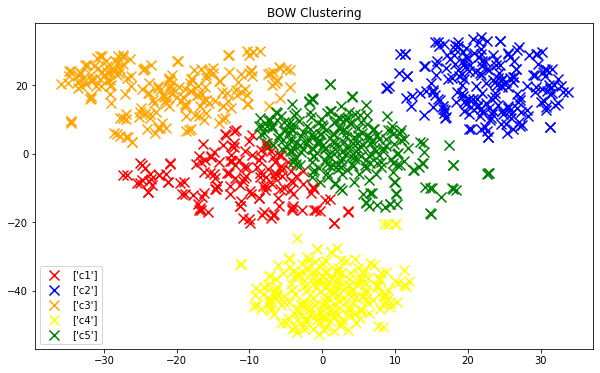

In [137]:
plotting(bow_features_reduced, model_kmeans_bow, 'BOW Clustering')